## Importing Libraries


In [ ]:
############################# Let's import the necessary packages #############
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, LambdaCallback # Callbacks
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D # Layers
from keras.models import Sequential, Model # Model
from tensorflow.keras.applications.resnet50 import ResNet50 # Pretrained model
# from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator  # Data generator
from sklearn.model_selection import train_test_split  # Splitting data
from sklearn.metrics import confusion_matrix, classification_report  # Metrics
from sklearn.utils import shuffle  # Shuffling data
import matplotlib.pyplot as plt  # Plotting
from tensorflow import keras  # Keras API
import tensorflow as tf  # Tensorflow
from tqdm import tqdm  # Progress bar
import seaborn as sns  # Plotting
import numpy as np  # Linear algebra
import itertools  # Iterations
import datetime  # Time stamps
import torch  # Pytorch
import cv2  # Image processing
import os  # Accessing input images - Operation system dependent functionality
import io  # Reading and writing streams
import sys # System-specific parameters and functions
import time # Time access and conversions
from distutils.dir_util import copy_tree, remove_tree # Copying and removing directories
from google.colab import drive # Google colab

## Preprocessing




In [ ]:
# Autoreload reloads modules automatically before entering the execution of
# code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
DRIVE_MOUNT_PATH = '/content/drive'

##############################################################################

# Note tahat when using the 'Mount Drive' button in the file browser, no
# authentication codes are necessary for notebooks that have only been edited
# by the current user.

drive.mount(DRIVE_MOUNT_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Google_Drive_Path_AFTER_MYDRIVE contains the path of the folder where the
# dataset is stored in Google Drive.
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Skills - Legion/Deep Learning/hit dl course/exe_deep_learning/Final project/12.6.23'

##############################################################################

# We use os.path.join because it is the right way to join paths in Python.
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
# os.listdir function let us know what files are in the directory.
print(os.listdir(GOOGLE_DRIVE_PATH))

['Preprocessing.py', 'Alzheimer_s Dataset', '__pycache__', 'InvceptionV3_Weights=Imagenet_Transfer_learning_Data_augmentation.ipynb', 'InvceptionV3-Weights=Imagenet-Transfer_learning-Data augmentation.ipynb', 'InceptionResNetV2_Weights=Imagenet_Transfer_learning_Data_augmentation.ipynb', 'ResNet152V2_Weights=Imagenet_Transfer_learning_Data_augmentation.ipynb', 'Backup', 'Preprocessing_opencv.py', 'InceptionV3_98.21_better_initialization.ipynb', 'To Submit', 'InceptionV3_75_89.ipynb']


In [ ]:

# Sys.path.append is used to add the path to the list of paths to search for
# modules.
sys.path.append(GOOGLE_DRIVE_PATH)

# os.environ is a mapping object that represents the user's environmental
#  variables. we will use "TZ" to set the time
# zone to US/Eastern.
os.environ["TZ"] = "US/Eastern"


In [ ]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [ ]:
LABLES_LST = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
MERGE_PATH_PREFIX = '/content/drive/MyDrive/Skills - Legion/Deep Learning/hit dl course/exe_deep_learning/Final project/12.6.23/Alzheimer_s Dataset/merged'
TRAIN_PATH_PREFIX = '/content/drive/MyDrive/Skills - Legion/Deep Learning/hit dl course/exe_deep_learning/Final project/12.6.23/Alzheimer_s Dataset/train'
TEST_PATH_PREFIX = '/content/drive/MyDrive/Skills - Legion/Deep Learning/hit dl course/exe_deep_learning/Final project/12.6.23/Alzheimer_s Dataset/test'
NORMALIZATION_FACTOR = 255.0
IMAGE_SIZE_CUR = 176
GRAY_SCALE_MODE_ZERO = 0

############################################################################


# The list below contains the labels of the images - The true labels.
labels_cur = LABLES_LST

# x_train is a list of training images.
# x_train  -> x_train_lst
x_train_cur = []
# y_train is a list of training labels.
y_train_cur = []
# x_test is a list of testing images.
x_test_cur = []
# y_test is a list of testing labels.
y_test_cur = []
# Here we will keep the merged train+test sets
x_merged_cur = []
y_merged_cur = []

image_size = IMAGE_SIZE_CUR

if os.path.exists(MERGE_PATH_PREFIX):
    remove_tree(MERGE_PATH_PREFIX)

os.mkdir(MERGE_PATH_PREFIX)
copy_tree(TRAIN_PATH_PREFIX, MERGE_PATH_PREFIX)
copy_tree(TEST_PATH_PREFIX, MERGE_PATH_PREFIX)

for label in labels_cur:
    MERGE_PATH_LABEL = os.path.join(MERGE_PATH_PREFIX, label)
    # Go through all the files in the directory and read them.
    for file in tqdm(os.listdir(MERGE_PATH_LABEL)):
        def bilateral_filter_foo(image_c):
          """
          The function applies bilateral filter to the recieve image.
          """
          # cv2.bilateralFilter function applies bilateral filter to the image.
          # The function applies bilateral filter to
          # the input image.  Furthermore, bilateral filter can reduce unwanted
          # noise very well while keeping edges
          # fairly sharp. However, it is very slow compared to most filters.
          image_c = cv2.bilateralFilter(image_c, 2, 50, 50)
          return image_c

        def applyColorMap_foo(image_c):
          """
          The function applies a GNU Octave/MATLAB equivalent colormap on
          a given image.
          """
          # cv2.applyColorMap function applies a GNU Octave/MATLAB equivalent
          # colormap on a given image.
          image_c = cv2.applyColorMap(image_c, cv2.COLORMAP_BONE)
          return image_c

        def resize_foo(image_c, image_size):
          """
          The function resize the recieve image to the specified size.
          * Image_size - Integer.
          """
          # cv2.resize function resize the image to the specified size. On our
          # case we resize the image.
          image_c = cv2.resize(image_c, (image_size, image_size))
          return image_c

        # cv2.imread reads an image from a file. The flag specifies the way how
        # the image should be read -
        # On our case 0 means that the image should be read in grayscale mode.
        image_cur = cv2.imread(os.path.join(MERGE_PATH_LABEL, file),
                               GRAY_SCALE_MODE_ZERO)

        # cv2.bilateralFilter function applies bilateral filter to the image.
        # The function applies bilateral filter to
        # the input image.  Furthermore, bilateral filter can reduce unwanted
        # noise very well while keeping edges
        # fairly sharp. However, it is very slow compared to most filters.
        image_cur = bilateral_filter_foo(image_cur)

        # cv2.applyColorMap function applies a GNU Octave/MATLAB equivalent
        #colormap on a given image.
        image_cur = applyColorMap_foo(image_cur)

        # cv2.resize function resize the image to the specified size. On our
        # case we resize the image.
        image_cur = resize_foo(image_cur, image_size)

        # Append the image to the list.
        x_merged_cur.append(image_cur)
        # Append the label to the list.
        y_merged_cur.append(labels_cur.index(label))

# np.array function creates an array - On our case we create an array of train
# images that normalized to range 0 to 1.
x_merged_cur = np.array(x_merged_cur) / NORMALIZATION_FACTOR
# We shuffle the new merged dataset so that the original train and test datasets mix well with each other
x_merged_cur, y_merged_cur = shuffle(x_merged_cur,y_merged_cur, random_state=42)


100%|██████████| 2241/2241 [00:08<00:00, 270.62it/s]


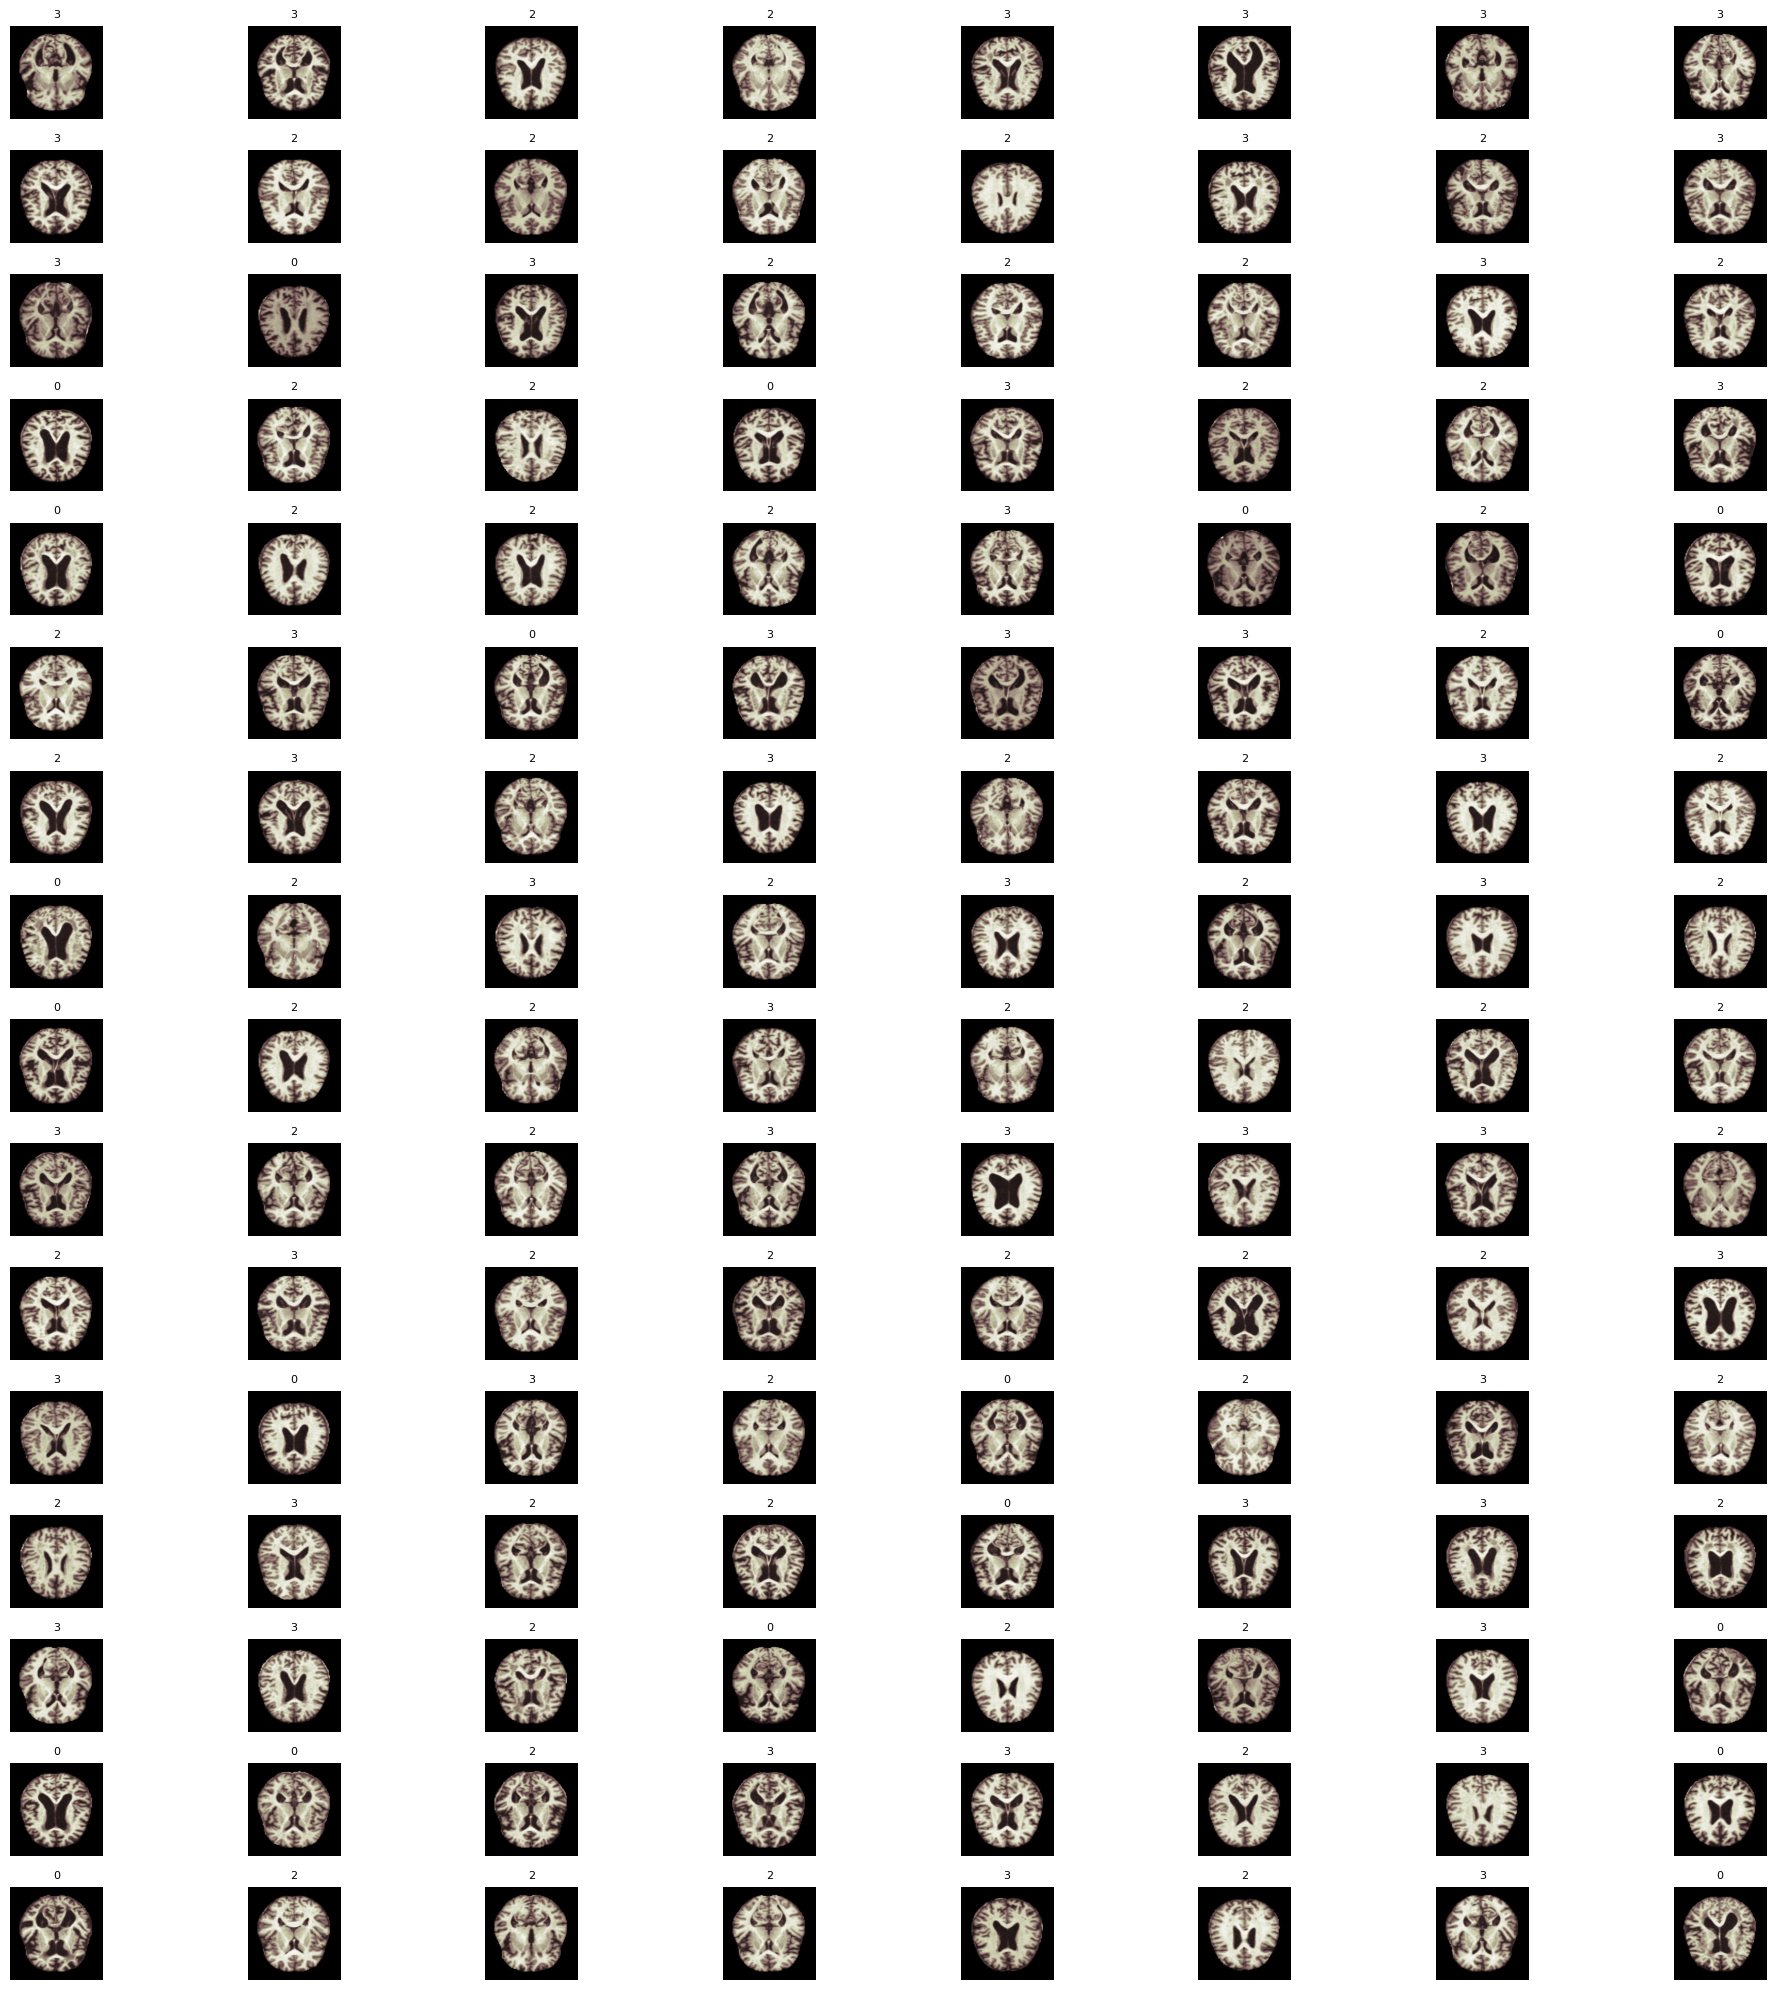

In [ ]:
images = [x_merged_cur[i] for i in range(128)]
fig, axes = plt.subplots(16, 8, figsize = (20, 20))
fig.subplots_adjust(wspace=0.2, hspace=0.2)
axes = axes.flatten()
i=0
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.set_title(y_merged_cur[i],fontsize = 8)
    i += 1
    ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
#Turning labels into One-hot-encoding categories
y_merged_cur = tf.keras.utils.to_categorical(y_merged_cur)

#Splitting the data into train, validation, and test sets

x_train_cur, x_test_cur, y_train_cur, y_test_cur = train_test_split(x_merged_cur, y_merged_cur, test_size = 0.2, random_state=8)
x_train_cur, x_val, y_train_cur, y_val = train_test_split(x_train_cur, y_train_cur, test_size = 0.2, random_state=8)

print(x_merged_cur.shape)
print(x_train_cur.shape)
print(x_val.shape)
print(x_test_cur.shape)

(6414, 176, 176, 3)
(4104, 176, 176, 3)
(1027, 176, 176, 3)
(1283, 176, 176, 3)


## Data Augmentation

In [ ]:
ROTATION_RANGE = 10


##############################################################################

# ImageDataGenerator transforms each image in the batch by a series of random
# translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=ROTATION_RANGE)
"""
,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)
"""
# After we have created and configured your ImageDataGenerator, we must fit
# it on our data.
datagen.fit(x_train_cur)

## Neural Network Architecture (Using Pre-trained Model)


In [ ]:
WEIGHTS_STR = 'imagenet'

##############################################################################

from keras import applications

# ResNet50 is a pre-trained model that was trained on the ImageNet dataset.
net_using_pre_trained_model = applications.InceptionV3(
    weights=WEIGHTS_STR, # We chose to use the weights that were trained on the
    # ImageNet dataset.
     include_top=False, # We chose to not include the top layer of the network.
     input_shape=(image_size,image_size,3))

In [ ]:
RELU_ACTIVATION_STR = 'relu'
SOFTMAX_ACTIVATION_STR = "softmax"
LOSS_CATEGORICAL_CROSSENTROPY_STR = 'categorical_crossentropy'
EVALUATION_MATRIX_ACCURACY_STR = 'accuracy'

#################################################################################


# net.output is the output of the ResNet50 model.
model_cur = net_using_pre_trained_model.output
# We use GlobalAveragePooling2D layer to reduce the number of parameters
#  in our model.
model_cur = GlobalAveragePooling2D()(model_cur)

# We use Dense layer to create a fully connected layer with 4 neurons. We chose
#  to use softmax activation function.
model_cur = Dense(4, activation=SOFTMAX_ACTIVATION_STR)(model_cur)
# Let's create our model.
model_cur = Model(inputs= net_using_pre_trained_model.input, outputs= model_cur)

# We use Adam optimizer to optimize our model. We chose to use learning rate of
# 0.0001.
# The learning rate is a hyperparameter that controls how much to change the
# model in response to the estimated error
# each time the model weights are updated.
adam_optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# We chose to use categorical_crossentropy as our loss function.
model_cur.compile(optimizer=adam_optimizer, loss =
                  LOSS_CATEGORICAL_CROSSENTROPY_STR,
                  metrics=[EVALUATION_MATRIX_ACCURACY_STR])


In [ ]:
# Let's check our model summary. You can check how many parameters are in
# each layer and the total number of parameters.
# Furthermore, you can check the output shape of each layer and the total
# number of trainable parameters.
TO_SHOW_MODEL_SUMMARY = True
if TO_SHOW_MODEL_SUMMARY:
  model_cur.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 176, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 87, 87, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 87, 87, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

## Model Training

In [ ]:
def show_loss_curves():
  """
  The function show the loss curves.
  """
  # Let's plot the loss curves.
  plt.figure(figsize=[8,6])
  plt.plot(history_cur.history['loss'],COLOR_STR_TRAINING_LOSS, linewidth=3.0)
  # We use blue color to plot the validation loss.
  plt.plot(history_cur.history['val_loss'],COLOR_STR_VAL_LOSS,linewidth=3.0)
  # We use legend to show the labels of the plots.
  plt.legend(['Training loss', 'Validation Loss'],fontsize=FONT_SIZE_LEGEND)
  # We use xlabel method to set the label of the x axis.
  plt.xlabel('Epochs ',fontsize=FONT_SIZE_X_LABEL)
  # We use ylabel method to set the label of the y axis.
  plt.ylabel('Loss',fontsize=FONT_SIZE_Y_LABEL)
  # We use title method to set the title of the plot.
  plt.title('Loss Curves - Loss V.S Epoch',fontsize=FONT_SIZE_TITLE)
  plt.show()


def show_accuracy_curves():
  """
  The function show the accuracy curves.
  """
  # Let's plot the accuracy curves.
  plt.figure(figsize=[8,6])
  # We use red color to plot the training accuracy.
  plt.plot(history_cur.history['accuracy'],COLOR_STR_TRAINING_ACC,linewidth=3.0)
  # We use blue color to plot the validation accuracy.
  plt.plot(history_cur.history['val_accuracy'],COLOR_STR_VAL_ACC,linewidth=3.0)
  # We use legend to show the labels of the plots.
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=
  FONT_SIZE_LEGEND)
  # We use xlabel method to set the label of the x axis.
  plt.xlabel('Epochs ',fontsize=FONT_SIZE_X_LABEL)
  # We use ylabel method to set the label of the y axis.
  plt.ylabel('Accuracy',fontsize=FONT_SIZE_Y_LABEL)
  # We use title method to set the title of the plot.
  plt.title('Accuracy Curves - Accuracy V.S Epoch',fontsize=FONT_SIZE_TITLE)
  plt.show()


In [ ]:

"""
#create a writer variable for writing into the log folder.
file_writer_cm = tf.summary.create_file_writer(logdir)

tensorboard = TensorBoard(logdir, histogram_freq=1)


"The CNN was trained during 100 epochs, and the data was sent
to the network with a batch size of 20" -
Efficient Deep Neural Networks for Classification of Alzheimers.
"""

BATCH_SIZE = 20
EPOCHS = 100
FIRST_CLASS_WEIGHT = 1.0
SECOND_CLASS_WEIGHT = 1.0
THIRD_CLASS_WEIGHT = 1.0
FORTH_CLASS_WEIGHT = 1.0

#############################################################################

# Create model checkpoint callback to save the best model during training.
MC_best_model = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min'
, verbose=1, save_best_only=True)

# Create early stopping callback to stop the training if the validation
# loss doesn't improve for 3 epochs.
ES_by_val_loss_delta = EarlyStopping(monitor='val_loss', min_delta=0.001,
                                     patience=8, mode='min',
                                     restore_best_weights=True, verbose=1)
# Create reduce learning rate on plateau callback to reduce the learning rate
# by 0.2 if the validation loss doesn't
# improve for 1 epoch.
RL_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,
                                  min_lr=0.00001, verbose=1)


# CALL_BACKS = [ES,RL,tensorboard,MC,
#LambdaCallback(on_epoch_end=log_confusion_matrix)]

CALL_BACKS = [ES_by_val_loss_delta, RL_on_plateau, MC_best_model]


# The class weight is used to balance the data. We chose to give more weight
# to the class 1.
CLASS_WEIGHT_dict = {0: FIRST_CLASS_WEIGHT,
                     1: SECOND_CLASS_WEIGHT,
                     2: THIRD_CLASS_WEIGHT,
                     3: FORTH_CLASS_WEIGHT}

# Let's train our model.
history_cur = model_cur.fit(datagen.flow(x_train_cur, y_train_cur,
                                         batch_size=BATCH_SIZE),
                             validation_data = (x_val, y_val),
                             epochs = EPOCHS, callbacks = CALL_BACKS,
                             class_weight = CLASS_WEIGHT_dict)

Epoch 1/100
206/206 [==============================] - ETA: 0s - loss: 0.8513 - accuracy: 0.6194
Epoch 1: val_loss improved from inf to 0.96673, saving model to best_model.h5
206/206 [==============================] - 64s 144ms/step - loss: 0.8513 - accuracy: 0.6194 - val_loss: 0.9667 - val_accuracy: 0.6027 - lr: 1.0000e-04
Epoch 2/100
206/206 [==============================] - ETA: 0s - loss: 0.4434 - accuracy: 0.8233
Epoch 2: val_loss improved from 0.96673 to 0.76713, saving model to best_model.h5
206/206 [==============================] - 28s 136ms/step - loss: 0.4434 - accuracy: 0.8233 - val_loss: 0.7671 - val_accuracy: 0.7167 - lr: 1.0000e-04
Epoch 3/100
206/206 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.9020
Epoch 3: val_loss improved from 0.76713 to 0.60671, saving model to best_model.h5
206/206 [==============================] - 29s 138ms/step - loss: 0.2471 - accuracy: 0.9020 - val_loss: 0.6067 - val_accuracy: 0.8189 - lr: 1.0000e-04
Epoch 4/100
20

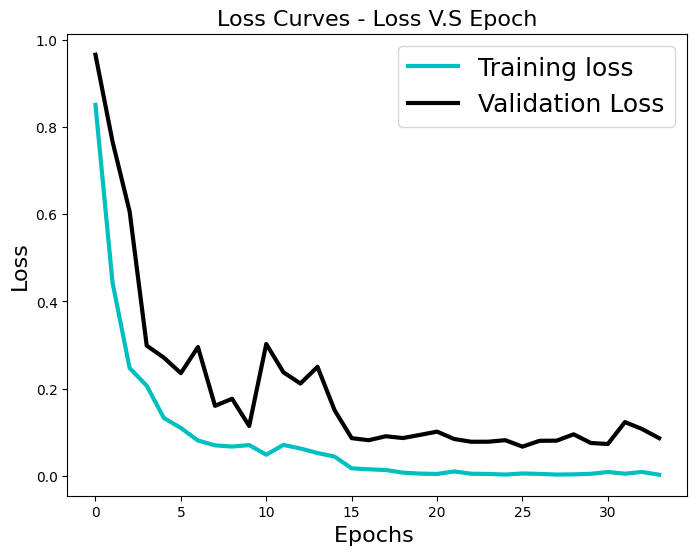

In [ ]:
COLOR_STR_TRAINING_LOSS = 'c'
COLOR_STR_VAL_LOSS = 'k'
FONT_SIZE_X_LABEL = 16
FONT_SIZE_Y_LABEL = 16
FONT_SIZE_LEGEND = 18
FONT_SIZE_TITLE = 16

###########################################################################


show_loss_curves()


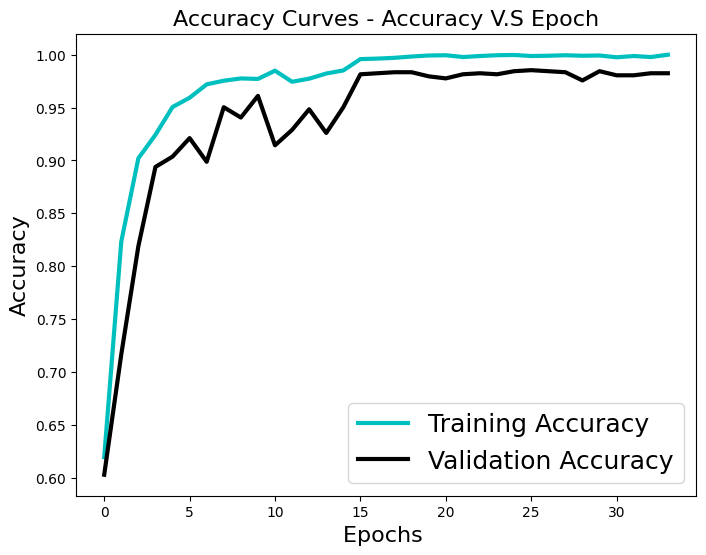

In [ ]:
COLOR_STR_TRAINING_ACC = 'c'
COLOR_STR_VAL_ACC = 'k'
FONT_SIZE_X_LABEL = 16
FONT_SIZE_Y_LABEL = 16
FONT_SIZE_LEGEND = 18
FONT_SIZE_TITLE = 16

###########################################################################


show_accuracy_curves()



## Model evaluationn

In [ ]:
FIRST_AXIS_ROWS = 1

# Let's import load_model method from keras.models.
from keras.models import load_model

# Now we have to load the saved model.
saved_model_h5 = load_model('best_model.h5')

# We use np.argmax method to get the index of the highest value in the array.
# Furthermore, We use axis = 1 to get the highest value in the rows.
# The predicted_classes is a 1D array that contains the predicted class for
# each image in the test set.
predicted_classes = np.argmax(saved_model_h5.predict(x_test_cur),
                              axis = FIRST_AXIS_ROWS)
confusionmatrix = confusion_matrix(np.argmax(y_test_cur, axis=FIRST_AXIS_ROWS),
                                   predicted_classes)

# Let's print the classification report which contains the precision, the
#recall and the f1-score.
print(classification_report(np.argmax(y_test_cur, axis=1), predicted_classes))

41/41 [==============================] - 3s 43ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       167
           1       0.89      1.00      0.94         8
           2       1.00      1.00      1.00       670
           3       1.00      0.99      0.99       438

    accuracy                           1.00      1283
   macro avg       0.97      1.00      0.98      1283
weighted avg       1.00      1.00      1.00      1283



In [ ]:
# We evaluate the model on the test set. The evaluate method returns the loss
# value and the accuracy values.
loss_cur,acc_cur = saved_model_h5.evaluate(x_test_cur, y_test_cur)

41/41 [==============================] - 3s 44ms/step - loss: 0.0190 - accuracy: 0.9953
